In [2]:
import pandas as pd

df = pd.read_csv('train.tsv', sep='\t')


In [3]:
df.info()
df.isnull().sum()
df.drop(['SentenceId','PhraseId'],axis=1,inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [4]:
df['Sentiment'].value_counts()

Sentiment
2    79582
3    32927
1    27273
4     9206
0     7072
Name: count, dtype: int64

In [5]:
df['label'] = df.pop('Sentiment')

In [6]:
sentiment_mapping = {
    0: "negative",
    1: "somewhat negative",
    2: "neutral",
    3: "somewhat positive",
    4: "positive"
}

# Adding the label_name column
df['label_name'] = df['label'].map(sentiment_mapping)

In [7]:
df

,Phrase,label,label_name
0,A series of escapades demonstrating the adage ...,1,somewhat negative
1,A series of escapades demonstrating the adage ...,2,neutral
2,A series,2,neutral
3,A,2,neutral
4,series,2,neutral
...,...,...,...
156055,Hearst 's,2,neutral
156056,forced avuncular chortles,1,somewhat negative
156057,avuncular chortles,3,somewhat positive
156058,avuncular,2,neutral


## Dataset Analysis

In [8]:
import matplotlib.pyplot as plt


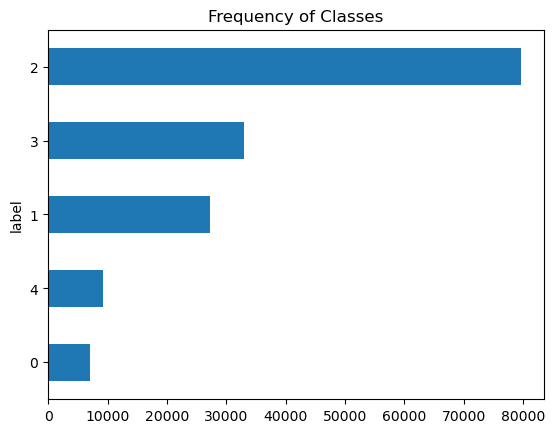

In [9]:
label_counts = df['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

<Axes: title={'center': 'Words per review'}, xlabel='label_name'>

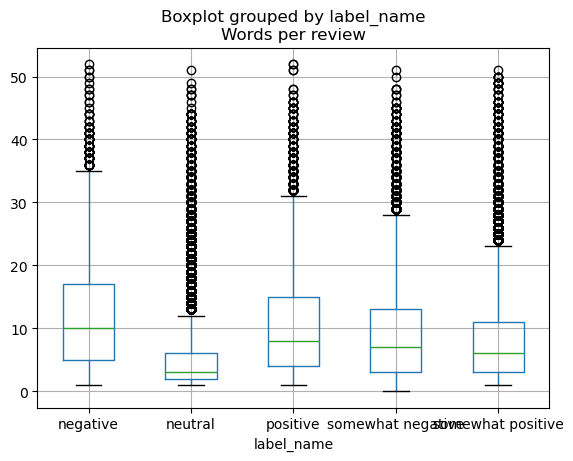

In [10]:
df['Words per review'] = df['Phrase'].str.split().apply(len)
df.boxplot("Words per review", by="label_name")
#df.drop(['Words per review'],axis=1,inplace=True)

## Text to Tokens Conversion
- Transformer models like BERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors.
- Tokenization is the step of breaking down a string into the atomic units used in the model

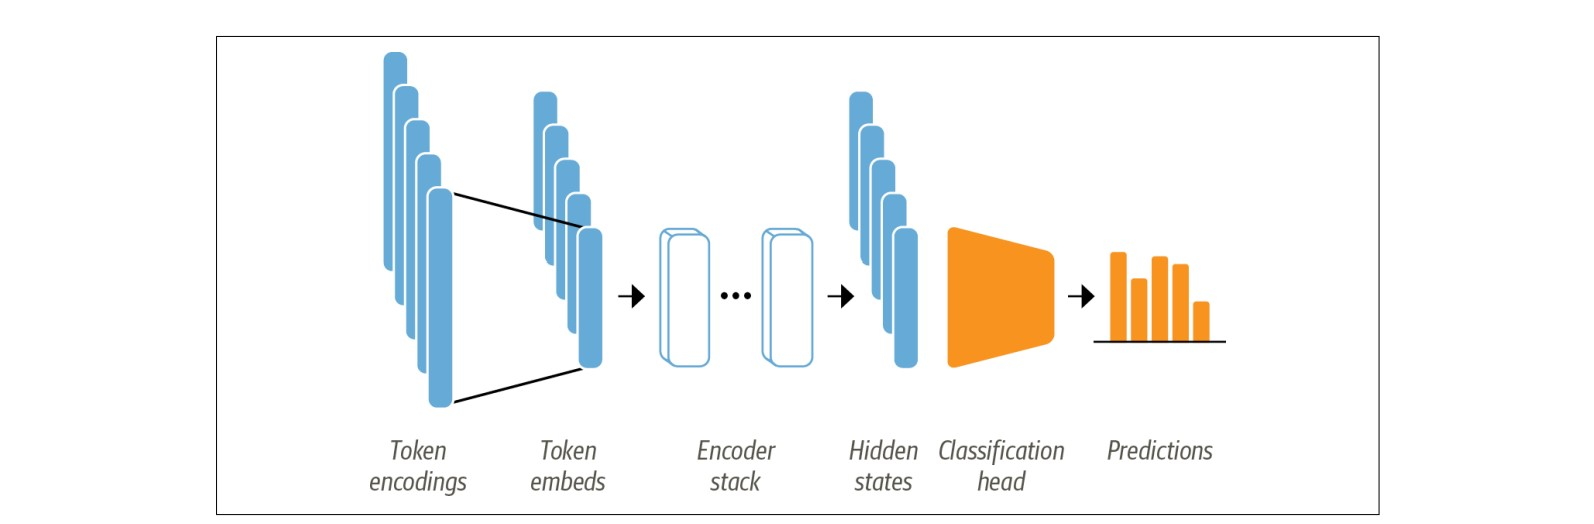

In [11]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


text = "I love machine learning! Tokenization is awesome!!"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [12]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

## Data Loader and Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label'])

train.shape, test.shape, validation.shape

((109242, 4), (31212, 4), (15606, 4))

In [14]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {'train':Dataset.from_pandas(train, preserve_index=False),
     'test':Dataset.from_pandas(test, preserve_index=False),
     'validation': Dataset.from_pandas(validation, preserve_index=False)
     }
     
)

dataset

DatasetDict({
    train: Dataset({
        features: ['Phrase', 'label', 'label_name', 'Words per review'],
        num_rows: 109242
    })
    test: Dataset({
        features: ['Phrase', 'label', 'label_name', 'Words per review'],
        num_rows: 31212
    })
    validation: Dataset({
        features: ['Phrase', 'label', 'label_name', 'Words per review'],
        num_rows: 15606
    })
})

## Tokenization of the Emotion/Sentiment Data

In [15]:
dataset['train'][0], dataset['train'][1]

({'Phrase': 'interminable , shapeless documentary',
  'label': 0,
  'label_name': 'negative',
  'Words per review': 4},
 {'Phrase': "Attal 's hang-ups surrounding infidelity are so old-fashioned",
  'label': 1,
  'label_name': 'somewhat negative',
  'Words per review': 8})

In [16]:
def tokenize(batch):
    temp = tokenizer(batch['Phrase'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 6970, 22311, 3468, 1010, 4338, 3238, 4516, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2012, 9080, 1005, 1055, 6865, 1011, 11139, 4193, 1999, 20740, 18605, 2024, 2061, 2214, 1011, 13405, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [17]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/109242 [00:00<?, ? examples/s]

Map:   0%|          | 0/31212 [00:00<?, ? examples/s]

Map:   0%|          | 0/15606 [00:00<?, ? examples/s]

In [18]:
# label2id, id2label

ds = [
    {'label_name': 'negative', 'label': 0},
    {'label_name': 'somewhat negative', 'label': 1},
    {'label_name': 'neutral', 'label': 2},
    {'label_name': 'somewhat positive', 'label': 3},
    {'label_name': 'positive', 'label': 4}
]

label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'negative': 0,
  'somewhat negative': 1,
  'somewhat positive': 3,
  'neutral': 2,
  'positive': 4},
 {0: 'negative',
  1: 'somewhat negative',
  3: 'somewhat positive',
  2: 'neutral',
  4: 'positive'})

## Model Building

In [19]:
from transformers import AutoModel 
import torch

In [20]:
model = AutoModel.from_pretrained(model_ckpt)

2025-01-14 12:33:16.668756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736875997.118650    6599 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736875997.231392    6599 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 12:33:18.884175: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model.config.id2label
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Fine-Tuning Transformers

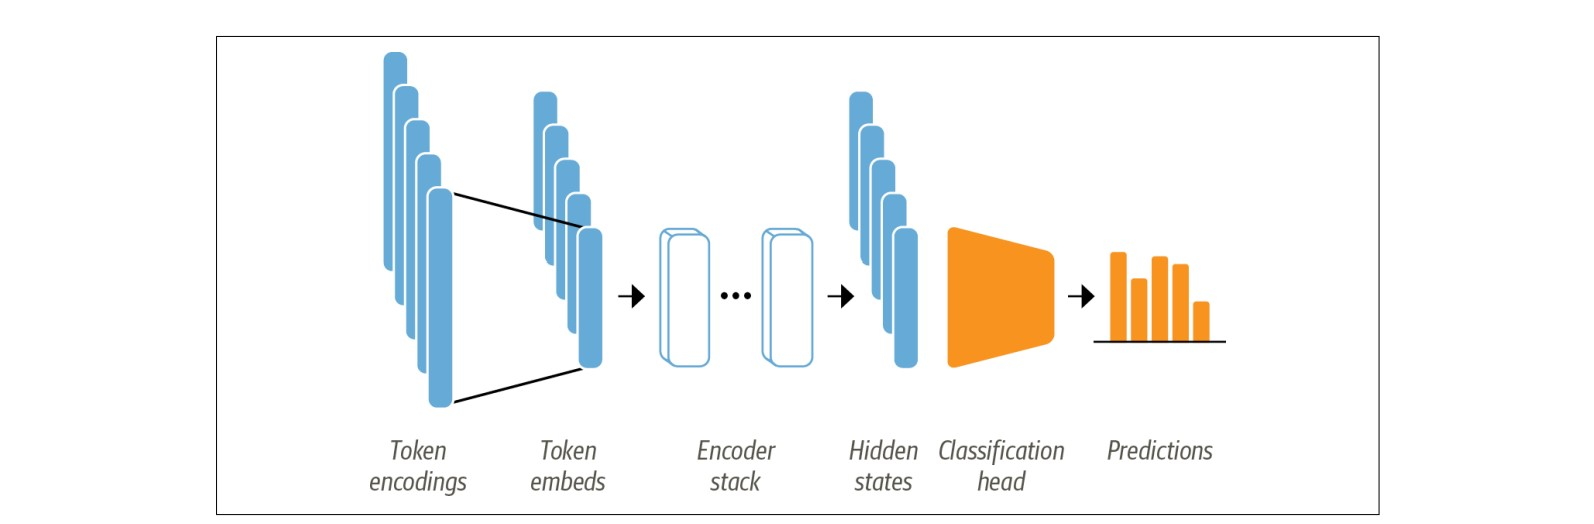

- `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs

- The first thing we need is a pretrained BERT model like the one we used in the feature-based approach.
- The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of AutoModel.
- The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model.

In [22]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
torch.cuda.is_available()

True

In [24]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "somewhat negative",
    "2": "neutral",
    "3": "somewhat positive",
    "4": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 2,
    "positive": 4,
    "somewhat negative": 1,
    "somewhat positive": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [25]:
from transformers import TrainingArguments

batch_size = 64
training_dir = "bert_base_train_dir"

training_args = TrainingArguments( output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 3,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = 'epoch',
                                  disable_tqdm = False
)

/home/howard/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
# Build compute metrics function
# !pip install evaluate
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)



In [27]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
 
    return {"accuracy": acc, "f1": f1}


## Build Model and Trainer

In [28]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = emotion_encoded['train'],
                  eval_dataset = emotion_encoded['validation'],
                  tokenizer = tokenizer)

/tmp/ipykernel_6599/1591179924.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.764800,0.723010,0.701781,0.701910
2,0.664000,0.707159,0.704857,0.703141
3,0.594400,0.724939,0.701012,0.701452


TrainOutput(global_step=5121, training_loss=0.6885432977272277, metrics={'train_runtime': 2778.3132, 'train_samples_per_second': 117.959, 'train_steps_per_second': 1.843, 'total_flos': 1.3136701554410616e+16, 'train_loss': 0.6885432977272277, 'epoch': 3.0})

## Model Evaluation

In [30]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.732681155204773,
 'test_accuracy': 0.6959823144944253,
 'test_f1': 0.6964149251956512,
 'test_runtime': 89.113,
 'test_samples_per_second': 350.252,
 'test_steps_per_second': 5.476}

In [31]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.52      0.52      1414
           1       0.59      0.62      0.60      5455
           2       0.79      0.79      0.79     15917
           3       0.63      0.60      0.61      6585
           4       0.56      0.61      0.58      1841

    accuracy                           0.70     31212
   macro avg       0.62      0.63      0.62     31212
weighted avg       0.70      0.70      0.70     31212



In [33]:
label2id

{'negative': 0,
 'somewhat negative': 1,
 'somewhat positive': 3,
 'neutral': 2,
 'positive': 4}

In [34]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

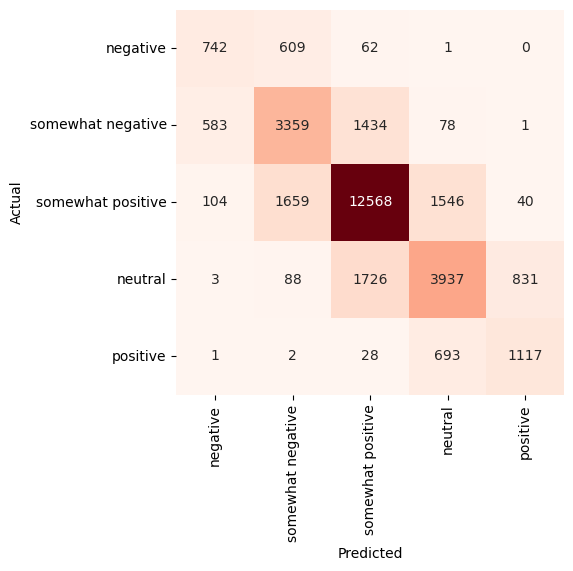

In [35]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## Build Prediction Function and Store Model

In [36]:
text = "I am super happy today. I got it done. Finally!!"

def get_prediction(text):
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**input_encoded)

    logits = outputs.logits

    pred = torch.argmax(logits, dim=1).item()
    return id2label[pred]

get_prediction(text)

'positive'

In [37]:
trainer.save_model("bert-base-uncased-sentiment-model")


In [38]:
# use pipeline for prediciton
from transformers import pipeline

classifier = pipeline('text-classification', model= 'bert-base-uncased-sentiment-model')

classifier([text, 'hello, how are you?', "love you", "i am feeling low"])

Device set to use cuda:0


[{'label': 'positive', 'score': 0.8416805267333984},
 {'label': 'neutral', 'score': 0.7080151438713074},
 {'label': 'somewhat positive', 'score': 0.7243324518203735},
 {'label': 'somewhat negative', 'score': 0.7641361951828003}]